In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor

In [2]:
file_path = 'House Price Prediction.csv'
data = pd.read_csv(file_path)


In [3]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Id             1460 non-null   int64
 1   MSSubClass     1460 non-null   int64
 2   LotArea        1460 non-null   int64
 3   OverallQual    1460 non-null   int64
 4   OverallCond    1460 non-null   int64
 5   YearBuilt      1460 non-null   int64
 6   YearRemodAdd   1460 non-null   int64
 7   BsmtFinSF1     1460 non-null   int64
 8   BsmtUnfSF      1460 non-null   int64
 9   TotalBsmtSF    1460 non-null   int64
 10  1stFlrSF       1460 non-null   int64
 11  2ndFlrSF       1460 non-null   int64
 12  GrLivArea      1460 non-null   int64
 13  BsmtFullBath   1460 non-null   int64
 14  FullBath       1460 non-null   int64
 15  HalfBath       1460 non-null   int64
 16  BedroomAbvGr   1460 non-null   int64
 17  KitchenAbvGr   1460 non-null   int64
 18  TotRmsAbvGrd   1460 non-null   int64
 19  Firepl

In [4]:
print(data.describe())


                Id   MSSubClass        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean    730.500000    56.897260   10516.828082     6.099315     5.575342   
std     421.610009    42.300571    9981.264932     1.382997     1.112799   
min       1.000000    20.000000    1300.000000     1.000000     1.000000   
25%     365.750000    20.000000    7553.500000     5.000000     5.000000   
50%     730.500000    50.000000    9478.500000     6.000000     5.000000   
75%    1095.250000    70.000000   11601.500000     7.000000     6.000000   
max    1460.000000   190.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   BsmtFinSF1    BsmtUnfSF  TotalBsmtSF  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   443.639726   567.240411  1057.429452  ...   
std      30.202904     20.645407   456.098091   441.866955   438.705324  ..

In [5]:
print(data.isnull().sum())


Id               0
MSSubClass       0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
BsmtFinSF1       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64


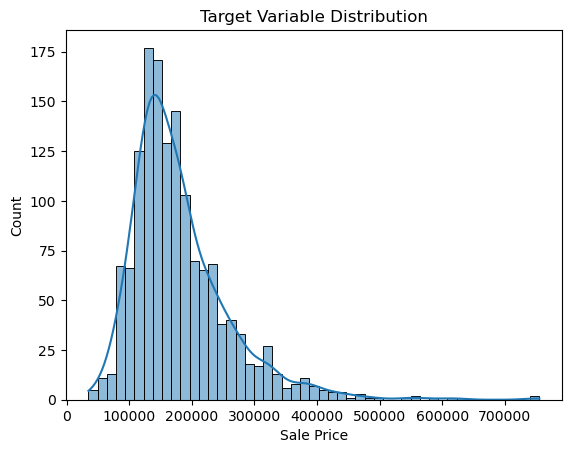

In [6]:
sns.histplot(data['SalePrice'], kde=True)
plt.title('Target Variable Distribution')
plt.xlabel('Sale Price')
plt.show()

In [7]:
data.fillna(data.median(), inplace=True)

In [8]:
data = pd.get_dummies(data, drop_first=True)

In [9]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
skewed_features = data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)


In [13]:
for feature in skewed_features.index:
    if skewed_features[feature] > 1:
        data[feature] = data[feature].apply(lambda x: np.log1p(x) if x > 0 else x)

In [14]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (1168, 31), (1168,)
Testing data shape: (292, 31), (292,)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
svm_model = SVR()
param_grid = {
    'kernel': ['rbf', 'linear'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.5, 1]
}

In [17]:
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.5, 1],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_mean_squared_error')

In [18]:
best_svm_model = grid_search.best_estimator_

# Making predictions
y_pred_svm = best_svm_model.predict(X_test_scaled)

In [19]:
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
print("SVM Model Performance:")
print(f"Mean Squared Error: {mse_svm}")
print(f"R2 Score: {r2_svm}")


SVM Model Performance:
Mean Squared Error: 0.019478182523304466
R2 Score: 0.8956214600727463


In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [22]:
y_pred_rf = rf_model.predict(X_test_scaled)

In [23]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Model Performance:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R2 Score: {r2_rf}")

Random Forest Model Performance:
Mean Squared Error: 0.022443673822463157
R2 Score: 0.8797301595572686


In [24]:
cv_svm = cross_val_score(best_svm_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

print("Cross-validation performance (Negative MSE):")
print(f"SVM CV mean: {-cv_svm.mean()}")
print(f"Random Forest CV mean: {-cv_rf.mean()}")

Cross-validation performance (Negative MSE):
SVM CV mean: 0.0197240057857723
Random Forest CV mean: 0.021536405649213924
